In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# uses modified version of scanpy
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install numpy
!pip install leidenalg

import os, sys
%cd "/content/drive/MyDrive/Colab Notebooks/scanpy"
sys.path.append(os.getcwd())
import os
import time
SCRIPT_DIR = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/')
!pip install -e "/content/drive/MyDrive/Colab Notebooks/scanpy"
import scanpy as sc
import anndata as ann
import pandas as pd
import scipy.io
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from matplotlib import figure
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

# INPUT_DATA = os.path.join(SCRIPT_DIR, "DATA","sc2")
DF_PROCESSEDv4_DATAPATH = os.path.join(SCRIPT_DIR, "DATA","DF","df_processedv4.h5ad")
FIGURE_DIR = os.path.join(SCRIPT_DIR, "Plots", "Initial_Clustering")
!pip freeze "/content/drive/MyDrive/Colab Notebooks/DATA/requirements.txt"

In [146]:
# Trains binary classifier on provided cluster
def train_classifier(t2, scm, clust_idx, use_xgboost=True, method='exact', n_estimators=1000, max_depth=7):
  f2 = scm.obs['Timepoint'] == t2
  X2 = scm[f2].X
  y2 = (scm[f2]).obs[clust_idx]
  if use_xgboost:
    param_dist = {'method':'exact', 'n_estimators':n_estimators, 
                  'max_depth': max_depth, 'binary':'logistic'}
  else: #TODO: random forest classifier
    print("Random forest not implemented yet")
    return
  clf = XGBClassifier(**param_dist)
  start = time.time()
  X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.9, test_size=0.1, random_state=2)
  if len(y2_train.unique()) != len(y2_test.unique()):
    raise ValueError("Train and test labels do not overlap")
  clf.fit(X2_train, y2_train)
  plot_confusion_matrix(clf,X2_test,y2_test)
  end = time.time()
  print("Model split and trained using {} in {} seconds".format(method, end-start))
  return X2_train, X2_test, y2_train, y2_test, clf

def timepoint_probabilities(scm, tp, clust, plots, n_neighbors,min_dist, resolution):
  scm_n = scm[scm.obs['Timepoint'] == tp]
  start = time.time()
  sc.pp.neighbors(scm_n, n_neighbors,random_state=1)
  sc.tl.umap(scm_n, min_dist, n_components=2, random_state=1, alpha=1)
  plots.append(scm_n)
  stage = scm_n.obs['Stage'][0]
  sc.pl.scatter(scm_n, 
                title='Timepoint: {} ({}), cells: {}, NN= {}'.format(tp, stage ,scm_n.n_obs, n_neighbors),
                basis='umap', color=clust, 
                save='_UMAP_CLUSTPROB_{}_TIMEPOINT_{}.png'.format(clust,tp))
  end = time.time()
  print("Time to visualize: "+ str(end-start) + " seconds")

In [150]:
# Graph Boost method
def nn_cluster_assignment(scm, tp, clust_idx, n_neighbors=15, neighbors_cutoff = 0.5, iteration_cutoff=0.01):
  scm_t = scm[scm.obs['Timepoint'] == tp]
  sc.pp.neighbors(scm_t, n_neighbors=n_neighbors+1)
  srm = scm_t.obsp['distances']
  print("Number of edges connected to cell 0: {}", len(np.argwhere(srm[0,:])))
  continue_assigning = True
  start = time.time()
  while continue_assigning:
    n_unassigned_1 = scm_t[scm_t.obs[clust_idx] == 0].n_obs
    print("Number of cells not assigned to cluster {}: {}".format(clust_idx, n_unassigned_1))
    for cell_idx in range(srm.shape[0]):
      # skip checking on a cell_idx's neighbors if it is already assigned a cluster
      if scm_t.obs.at[scm_t.obs.index[cell_idx], clust_idx] == 1:
        continue
      nearest_obs = np.argwhere(srm[cell_idx,:])[:,1]
      vfunc = np.vectorize(lambda x: 1 if scm_t.obs.at[scm_t.obs.index[x], clust_idx] == 1 else 0)
      count_neighbors = np.sum(vfunc(nearest_obs))
      if count_neighbors/n_neighbors >= neighbors_cutoff:
        scm_t.obs.loc[scm_t.obs.index[cell_idx], clust_idx] = 1
    n_unassigned_2 = scm_t[scm_t.obs[clust_idx] == 0].n_obs
    # stop when new cells are being assigned to clusters at a very small proportion
    if n_unassigned_2 > (1-iteration_cutoff)*n_unassigned_1:
      continue_assigning = False
  print("Number of cells not assigned to cluster {}: {}".format(clust_idx, n_unassigned_2))
  end = time.time()
  print("Time elapsed to conduct graph boost on {} at timepoint: {}: {}".format(clust_idx, tp, end-start))
  return scm_t

In [153]:
plt.rcParams["figure.figsize"] = (9,9) 

scm_ml = ann.read(DF_PROCESSEDv4_DATAPATH)
scm_ml.obs['leiden'] = scm_ml.obs['leiden'].astype(int)

#  add columns for probability and cluster assignments (all zeroes for now)
t_final = scm_ml.obs['Timepoint'].max()
num_classes = len(scm_ml[scm_ml.obs['Timepoint'] == t_final].obs['leiden'].unique())
# Column 'p(ci)' represents probability that an observation belongs to cluster i at t_final
prob_df = pd.DataFrame(data=np.zeros((scm_ml.n_obs, num_classes)),
                       index=scm_ml.obs.index, 
                       columns=['p(c'+str(i)+')' for i in range(num_classes)])
# Column ci represents formal cell assignment, based off a later-specified p threshold of p(ci)
clust_df = pd.DataFrame(data=np.zeros((scm_ml.n_obs, num_classes)),
                                    index=scm_ml.obs.index, 
                                    columns=['c' + str(i) for i in range(num_classes)])
scm_ml.obs = pd.concat([scm_ml.obs,prob_df,clust_df],axis=1)

# Assign initial ci with 1's to signify a cell belongs to the last timepoint leiden clusters; rest will remain zero 
for clust_idx in clust_df:
  clust_num = int(clust_idx[1])
  f = (scm_ml.obs['leiden'] == clust_num) & (scm_ml.obs['Timepoint'] == t_final)
  scm_ml.obs.loc[f, clust_idx] = 1


Model split and trained using exact in 130.28035020828247 seconds


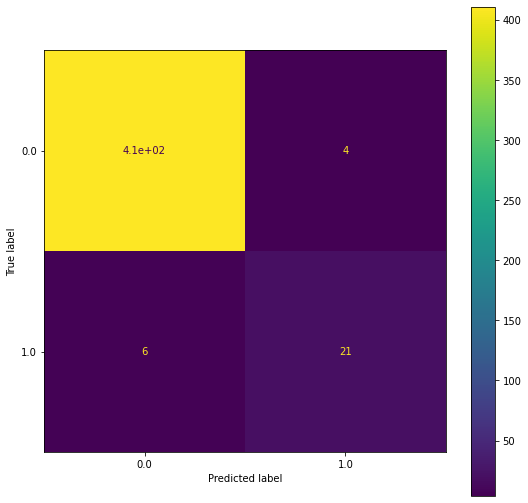

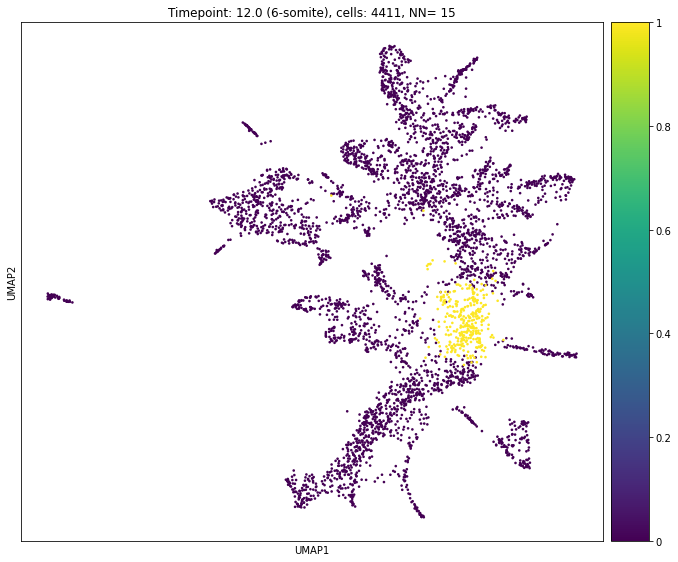

Time to visualize: 11.782172918319702 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c1: 1483
Number of cells not assigned to cluster c1: 1465
Number of cells not assigned to cluster c1: 1453
Time elapsed to conduct graph boost on c1 at timepoint: 11.0: 1.095144271850586


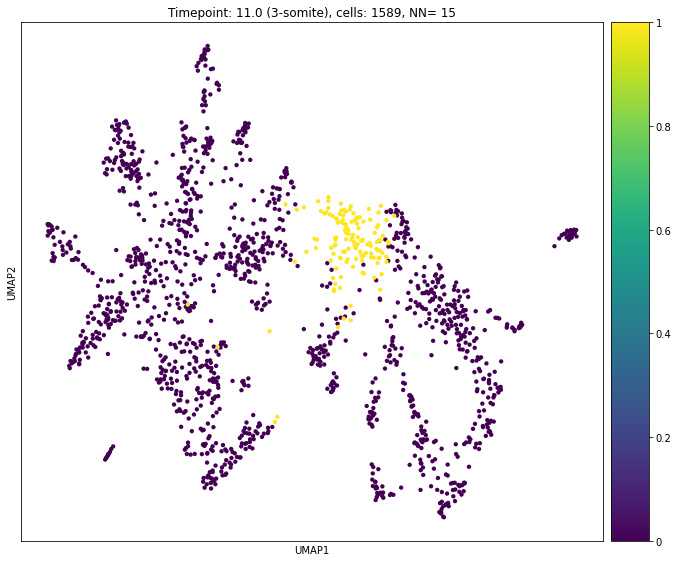

Time to visualize: 5.600507974624634 seconds
Model split and trained using exact in 32.90865731239319 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c1: 6700
Number of cells not assigned to cluster c1: 6575
Number of cells not assigned to cluster c1: 6471
Number of cells not assigned to cluster c1: 6408
Time elapsed to conduct graph boost on c1 at timepoint: 10.0: 7.268741846084595


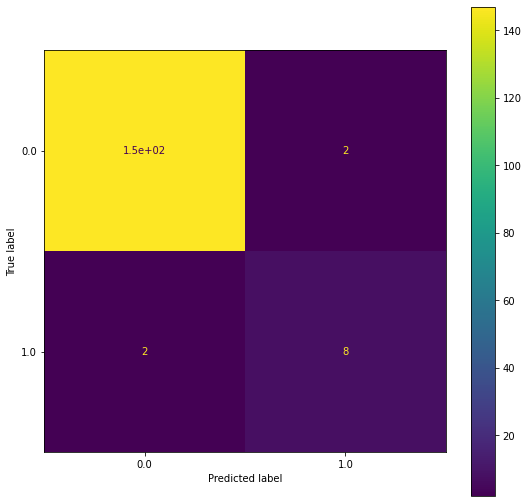

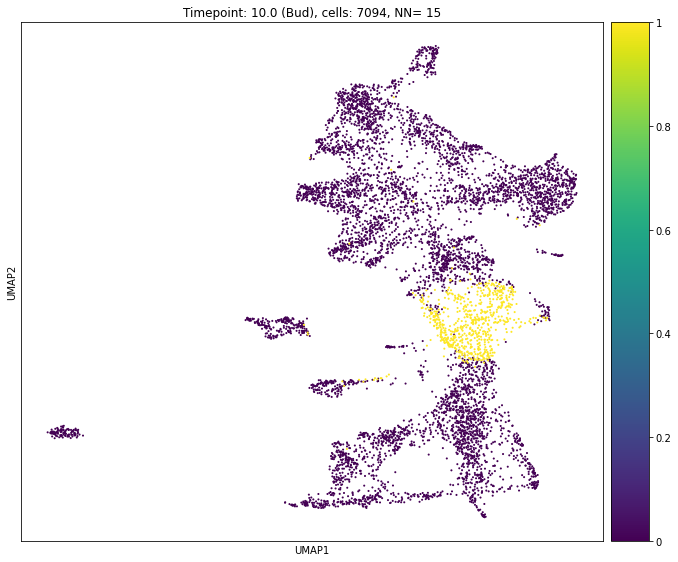

Time to visualize: 18.339024543762207 seconds
Model split and trained using exact in 216.95677518844604 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c1: 5084
Number of cells not assigned to cluster c1: 4927
Number of cells not assigned to cluster c1: 4864
Number of cells not assigned to cluster c1: 4822
Time elapsed to conduct graph boost on c1 at timepoint: 9.0: 5.355576038360596


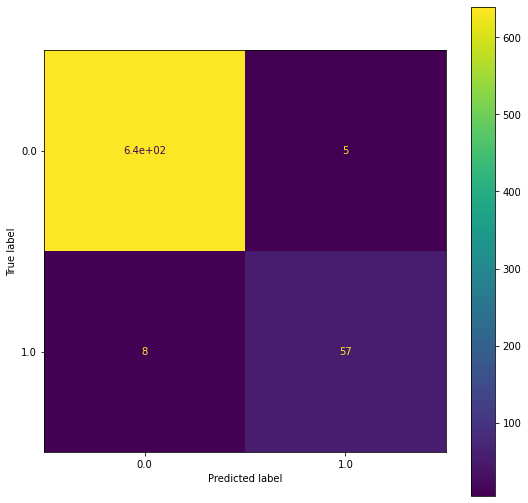

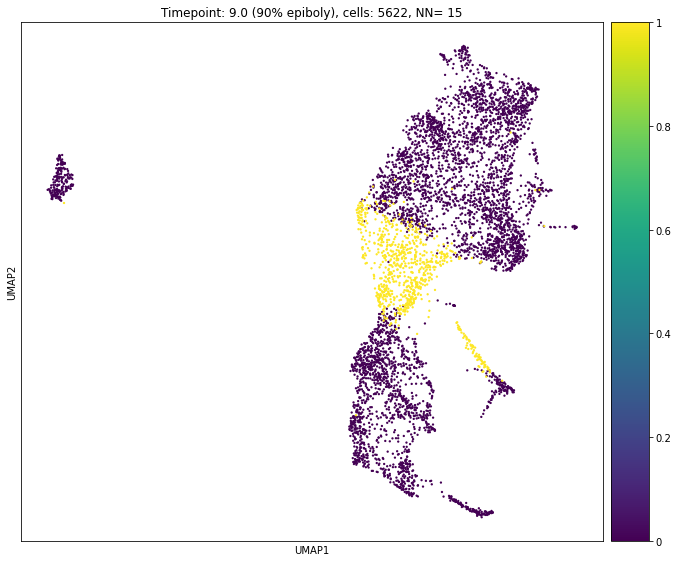

Time to visualize: 14.881728172302246 seconds
Model split and trained using exact in 179.70562171936035 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c1: 5510
Number of cells not assigned to cluster c1: 5386
Number of cells not assigned to cluster c1: 5351
Time elapsed to conduct graph boost on c1 at timepoint: 8.0: 3.9561026096343994


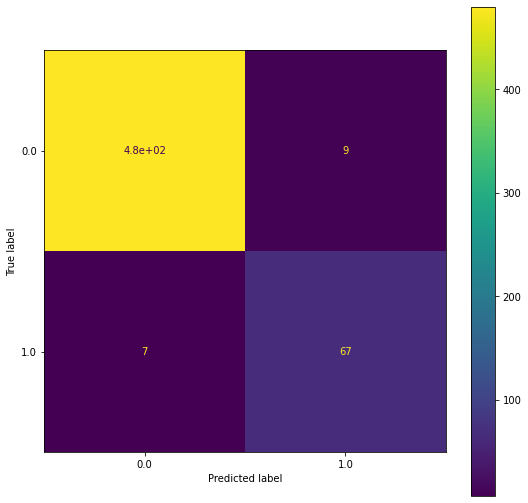

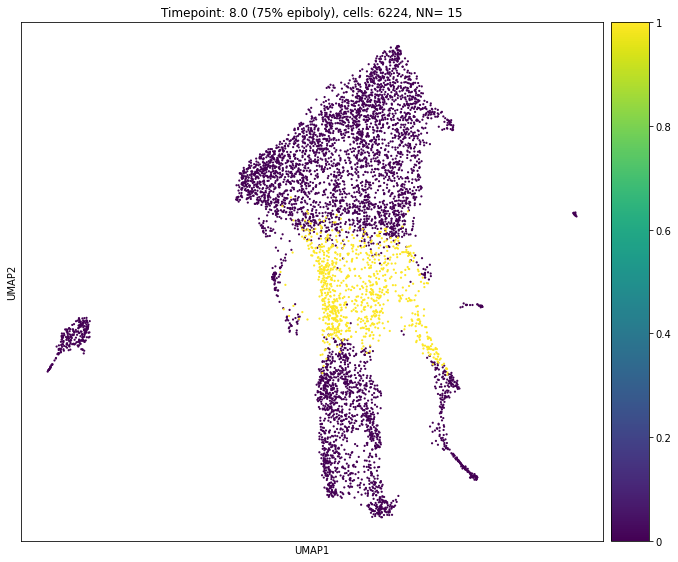

Time to visualize: 16.438145637512207 seconds
Model split and trained using exact in 189.92807364463806 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c1: 3698
Number of cells not assigned to cluster c1: 3630
Number of cells not assigned to cluster c1: 3616
Time elapsed to conduct graph boost on c1 at timepoint: 7.0: 2.6287686824798584


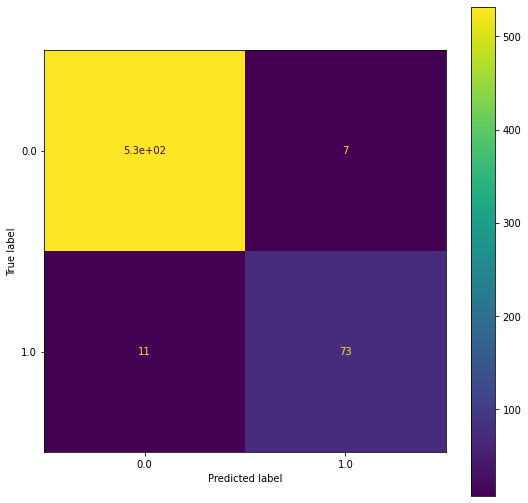

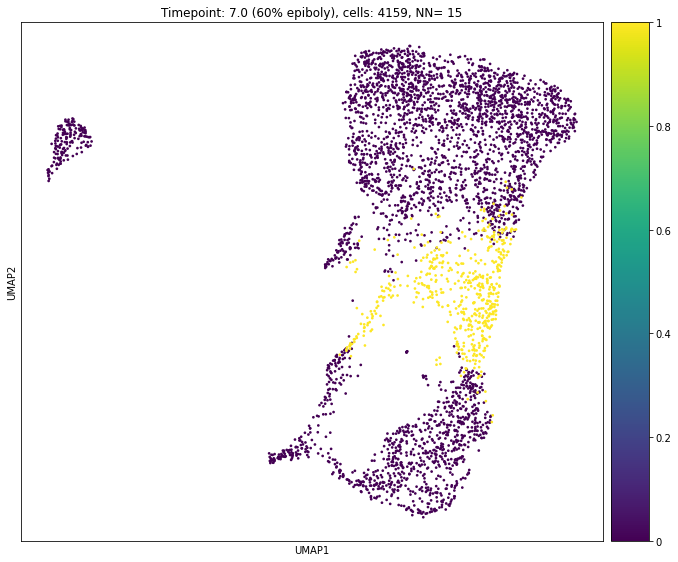

Time to visualize: 11.262900114059448 seconds
Model split and trained using exact in 94.88245391845703 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c1: 909
Number of cells not assigned to cluster c1: 881
Number of cells not assigned to cluster c1: 872
Number of cells not assigned to cluster c1: 871
Time elapsed to conduct graph boost on c1 at timepoint: 6.0: 1.0114903450012207


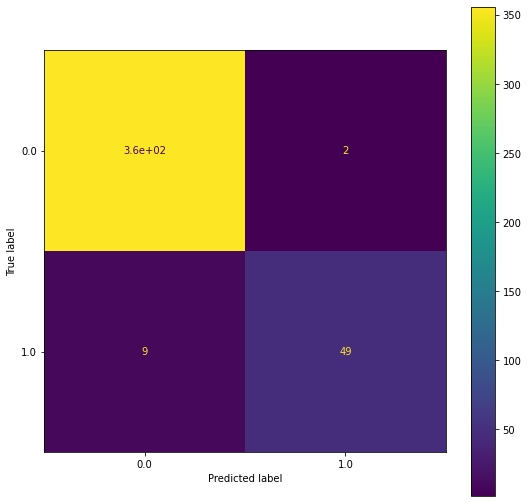

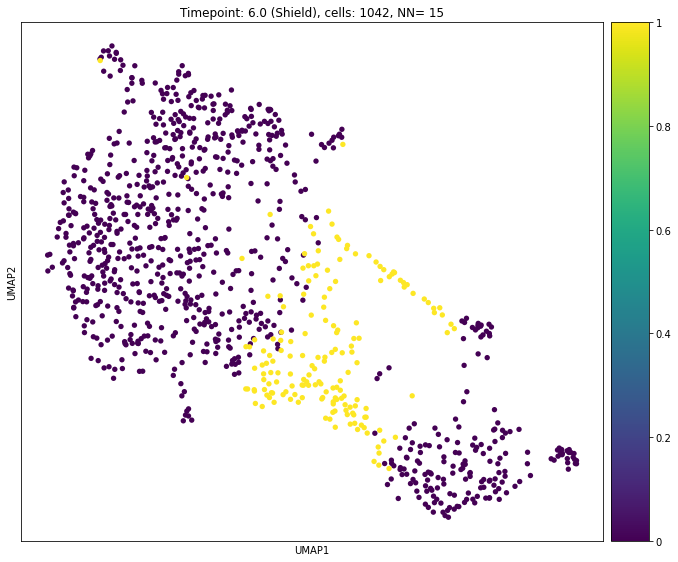

Time to visualize: 4.617257595062256 seconds
Model split and trained using exact in 20.20323657989502 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c1: 5205
Number of cells not assigned to cluster c1: 5063
Number of cells not assigned to cluster c1: 5013
Time elapsed to conduct graph boost on c1 at timepoint: 5.3: 3.7601492404937744


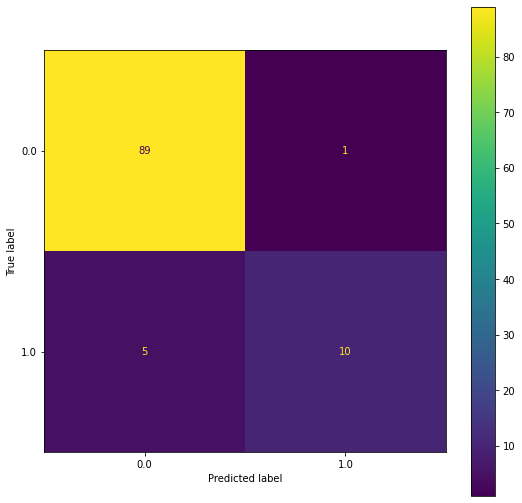

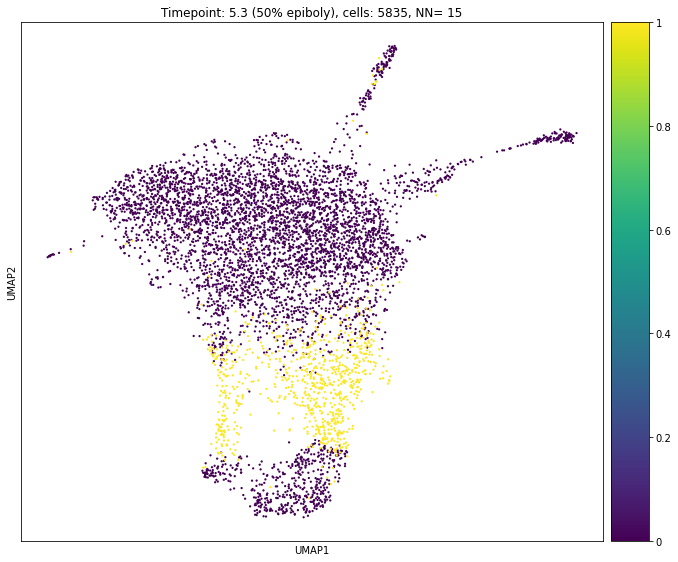

Time to visualize: 15.698211431503296 seconds
Model split and trained using exact in 175.85053133964539 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c1: 1269
Number of cells not assigned to cluster c1: 1239
Number of cells not assigned to cluster c1: 1208
Number of cells not assigned to cluster c1: 1184
Number of cells not assigned to cluster c1: 1183
Time elapsed to conduct graph boost on c1 at timepoint: 4.7: 1.8703982830047607


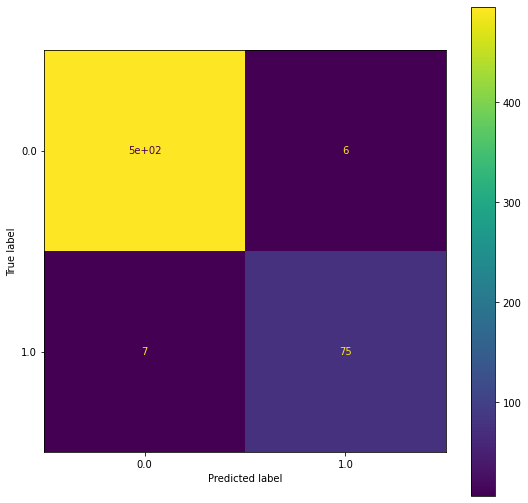

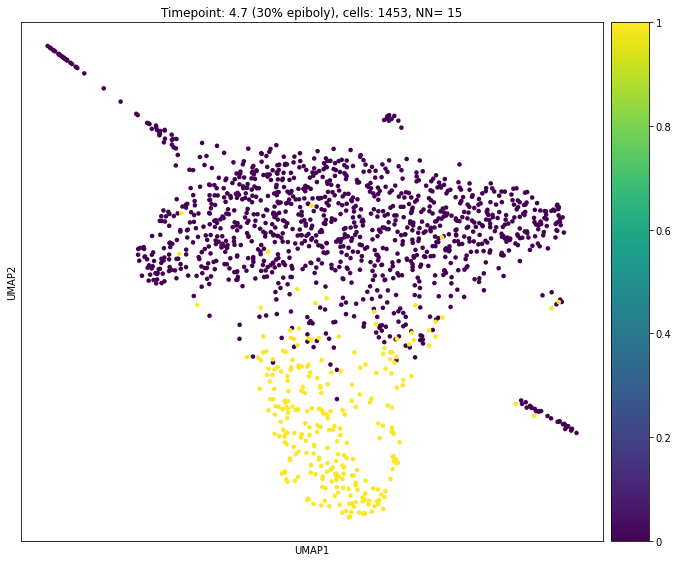

Time to visualize: 5.595268249511719 seconds
Model split and trained using exact in 21.63536787033081 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c1: 1030
Number of cells not assigned to cluster c1: 1028
Time elapsed to conduct graph boost on c1 at timepoint: 4.3: 0.3961668014526367


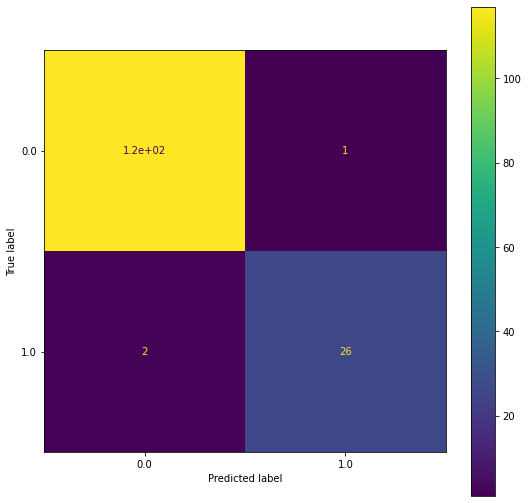

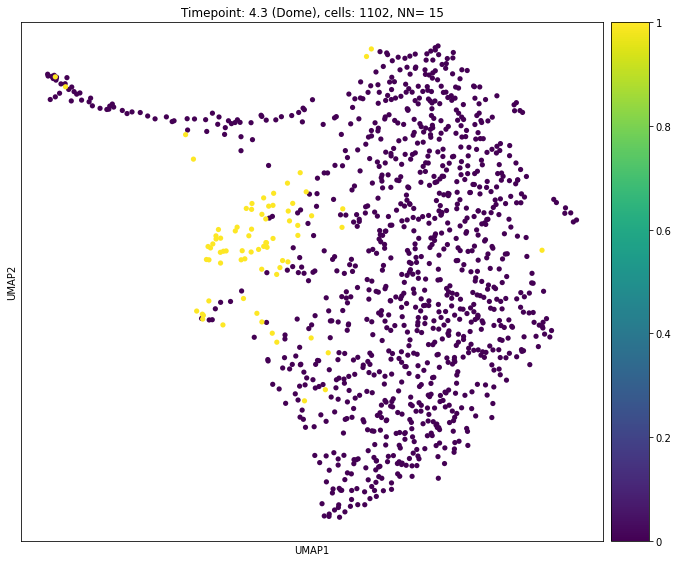

Time to visualize: 4.576352834701538 seconds
Model split and trained using exact in 13.338073968887329 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c1: 188
Number of cells not assigned to cluster c1: 188
Time elapsed to conduct graph boost on c1 at timepoint: 3.8: 0.10391569137573242


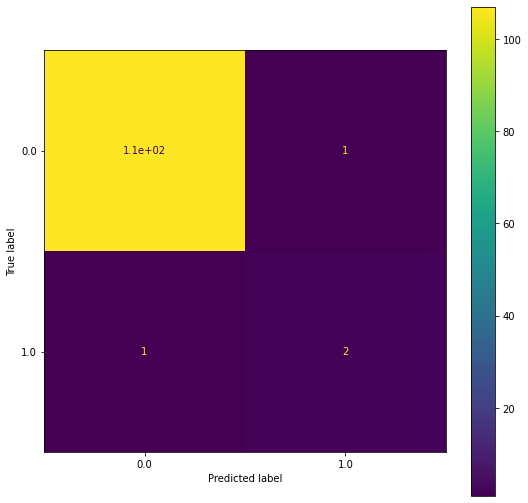

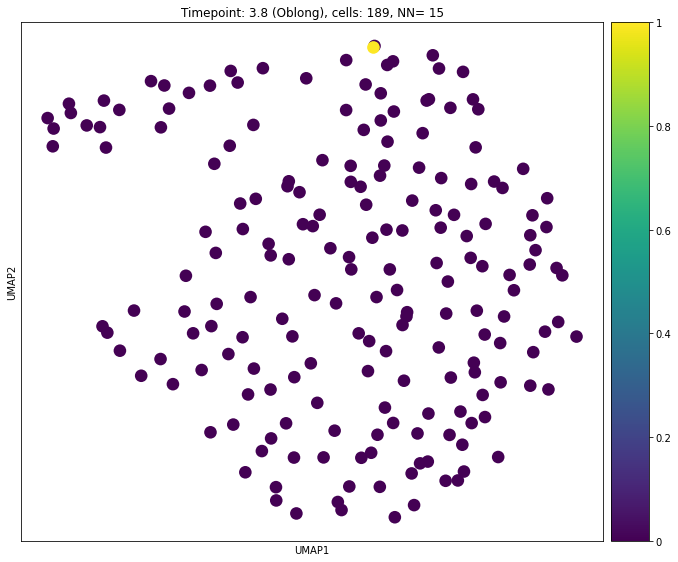

Time to visualize: 2.87005615234375 seconds


ValueError: ignored

In [154]:
timepoints = list(set(scm_ml.obs['Timepoint']))
timepoints.sort()
n_timepoints = len(set(scm_ml.obs['Timepoint']))
CLUST_IDS = [1]
p = 0.6
plots = []
for i in range(n_timepoints):
  for clust_id in CLUST_IDS:      
    t2 = timepoints[-1*(i+1)]
    t1 = timepoints[-1*(i+2)]
    clust_idx = 'c' + str(clust_id)
    prob_idx = 'p(' + clust_idx + ')'
    X2_train, X2_test, y2_train, y2_test, clf = train_classifier(t2=t2, scm=scm_ml, clust_idx=clust_idx)
    labels = y2_test.unique()
    labels.sort()
    # TO DO: Create nicer ML validation result
    # y2_pred = clf.predict(X2_test)
    # prf = precision_recall_fscore_support(y_true=y2_test, y_pred=y2_pred, average=None, labels=labels)
    # P_IDX = 0
    # R_IDX = 1
    # train_threshold = 0.8
    # trust_arr=[]
    # def det_trust(arr):
    #   trust_arr.append(arr[P_IDX] >train_threshold and arr[R_IDX] > train_threshold)
    # np.apply_along_axis(det_trust, axis=0, arr=prf)
    # print(trust_arr)
    if t2 == t_final:
      # Just for completion, assign probabilities for initial timepoint as well
      X_t2= scm_ml[scm_ml.obs['Timepoint'] == t2].X
      y_t2 = clf.predict_proba(X_t2)
      scm_ml.obs.loc[scm_ml.obs['Timepoint'] == t2,prob_idx] = y_t2[:,1]
      # plot
      timepoint_probabilities(scm_ml, t2, clust_idx, plots, n_neighbors=15, min_dist=0.3, resolution=1)
      # don't need to change cluster assignments since we already did that for t_final
    X_t1= scm_ml[scm_ml.obs['Timepoint'] == t1].X
    y_t1 = clf.predict_proba(X_t1)
    # update new probabilities at t1
    scm_ml.obs.loc[scm_ml.obs['Timepoint'] == t1,prob_idx] = y_t1[:,1]
    # update specified cluster's assignments for t1
    scm_ml.obs.loc[(scm_ml.obs['Timepoint'] == t1) & (scm_ml.obs[prob_idx] > p), clust_idx] = 1
    # conduct graph boosting for this specific cluster at t1
    scm_t = nn_cluster_assignment(scm_ml, t1, clust_idx)
    scm_ml.obs.loc[scm_ml.obs['Timepoint'] == t1, clust_idx] = scm_t.obs[clust_idx]
    timepoint_probabilities(scm_ml, t1, clust_idx, plots, n_neighbors=15, min_dist=0.3, resolution=1)
